In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
%config Inlinebackend.figure_format = 'svg'

from sklearn.metrics import r2_score as r2, mean_squared_error as mse, mean_absolute_error as mae

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings('ignore')

##### Функции для предобработки

In [2]:
def reduction_memory(df: pd.DataFrame):
    """function for reduction memory size"""
    
    df_c = df.copy()
    
    for column in df_c.columns:
    
        series = df_c[column]
        
        if series.dtype == 'float64':
            if (series != series.astype('float32')).sum() == 0:
                df_c[column] = series.astype('float32')
        elif series.dtype == 'int64':
            if (series != series.astype('int8')).sum() == 0:
                df_c[column] = series.astype('int8')
            elif (series != series.astype('int16')).sum() == 0:
                df_c[column] = series.astype('int16')
            elif (series != series.astype('int32')).sum() == 0:
                df_c[column] = series.astype('int32')
                
    return df_c

### 1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

In [3]:
PATH_TO_FILE = 'my_PJME_MW.csv'
# PATH_TO_FILE = '../input/ml-in-business/my_PJME_MW.csv'

df = pd.read_csv(PATH_TO_FILE) # read scv file
df['DateTime'] = (df['Date'] + ' ' + df['Time']).astype('datetime64') # concat and retype Date and Time
df = df.set_index('DateTime')      # set DateTime in index
df = reduction_memory(df)          # reduсe size
df_week = df.resample('W').mean()  # resample in weekly data
df_week[:2]

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
DateTime,,,,,,,,,,,,
2002-01-06,32392.160156,2002.0,1.0,3.517483,1.0,3.517483,1.0,3.517483,11.58042,0.160839,0.0,0.167832
2002-01-13,31487.386719,2002.0,1.0,10.000000,1.0,10.000000,2.0,3.000000,11.50000,0.000000,0.0,0.000000


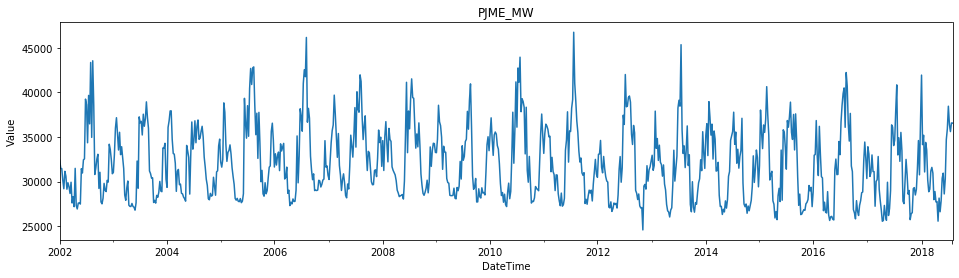

In [4]:
df_week['PJME_MW'].plot(figsize=(16, 4), title='PJME_MW')
plt.ylabel('Value')
plt.show()

### 2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков.

### 3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.

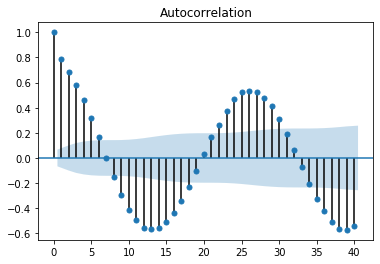

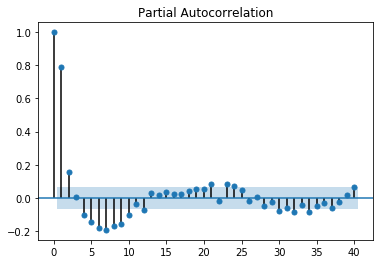

In [5]:
#ACF
sm.graphics.tsa.plot_acf(df_week['PJME_MW'], lags=40)
plt.show()
#PACF
sm.graphics.tsa.plot_pacf(df_week['PJME_MW'], lags=40)
plt.show()

                              ARMA Model Results                              
Dep. Variable:                PJME_MW   No. Observations:                  180
Model:                     ARMA(3, 2)   Log Likelihood               -1648.541
Method:                       css-mle   S.D. of innovations           2252.729
Date:                Tue, 10 Nov 2020   AIC                           3311.083
Time:                        18:19:55   BIC                           3333.433
Sample:                    02-01-2015   HQIC                          3320.145
                         - 07-08-2018                                         
============================================================================== =================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3.105e+04    327.613     94.

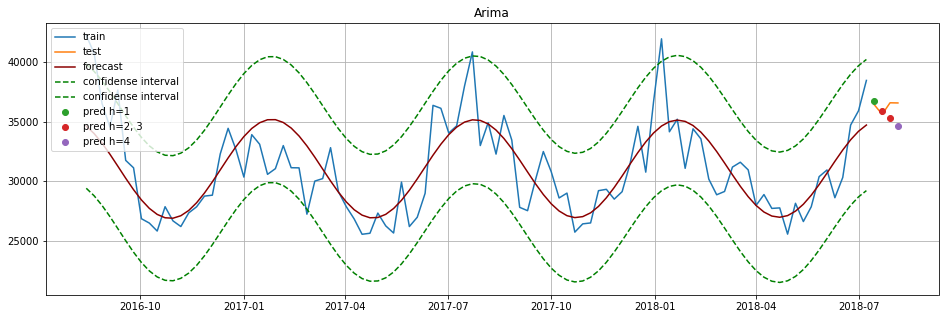

In [6]:
# spliting target
h = 4

y_train = df_week['PJME_MW'][:-h][-180:]
y_test = df_week['PJME_MW'][-h:]

# ARIMA
p, d, q = 3, 0, 2

model_arima = ARIMA(y_train, order=(p, d, q))

result = model_arima.fit(disp=False)

print(result.summary().tables[0], result.summary().tables[1])

# prediction
y_pred = result.predict(start=y_train.shape[0], end=y_train.shape[0]+h-1)

y_forecast = result.forecast(y_train.shape[0])

# plot
N = 100
plt.figure(figsize=(16,5))

# true values
plt.plot(y_train[-N:].index, y_train[-N:], label='train')
plt.plot(y_test.index, y_test, label='test')
# forecasts
plt.plot(y_train[-N:].index, y_forecast[0][-N:], color='darkred', label='forecast')
plt.plot(y_train[-N:].index, y_forecast[2][-N:], '--g', label='confidense interval')
# preds
plt.plot(y_pred.index[0], y_pred[0], 'o', label='pred h=1')
plt.plot(y_pred.index[1:3], y_pred[1:3], 'o', label='pred h=2, 3')
plt.plot(y_pred.index[3], y_pred[3], 'o', label='pred h=4')

plt.grid()
plt.title('Arima')
plt.legend(loc='upper left')
plt.show()

In [7]:
err = ((100 - (y_pred / y_test)*100)**2)**(1/2)

print(f'Проценты ошибки в предсказынных значениях:\n{err}\n\n', 
      f'Текущая средняя ошибка = {round(err.mean(), 2)}%', 
      sep='')

Проценты ошибки в предсказынных значениях:
2018-07-15    0.879293
2018-07-22    0.822153
2018-07-29    3.505001
2018-08-05    5.213818
Freq: W-SUN, dtype: float64

Текущая средняя ошибка = 2.61%


### 4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.

In [8]:
def train_test_split(X, y, date):
    """function for spliting data"""
    
    X_train = X[X.index < date]
    X_test = X[X.index >= date]
    
    y_train = y[y.index < date]
    y_test = y[y.index >= date]
    
    return X_train, X_test, y_train, y_test

In [9]:
def evaluate_pred(train_true, train_pred, test_true, test_pred):
    """
    function for evaluate prediction: 
    
        scatter: true, prediction,
        plot: true, prediction,
        calculates: R2, MSE, MAE
    """
    
    err_r2_train = round(r2(train_true, train_pred), 2)
    err_mse_train = round(mse(train_true, train_pred), 2)
    err_mae_train = round(mae(train_true, train_pred), 2)
    
    err_r2_test = round(r2(test_true, test_pred), 2)
    err_mse_test = round(mse(test_true, test_pred), 2)
    err_mae_test = round(mae(test_true, test_pred), 2)
    
    diff_r2 = round(((err_r2_train - err_r2_test)**2)**(1/2), 2)
    diff_mse = round(((err_mse_train - err_mse_test)**2)**(1/2), 2)
    diff_mae = round(((err_mae_train - err_mae_test)**2)**(1/2), 2)
    
    print(f'Train errors:\n\n', 
          f'\tR2 = {err_r2_train}\n', 
          f'\tMSE = {err_mse_train}\n', 
          f'\tMAE = {err_mae_train}\n')
    
    print(f'Test errors:\n\n', 
          f'\tR2 = {err_r2_test}\n', 
          f'\tMSE = {err_mse_test}\n', 
          f'\tMAE = {err_mae_test}\n')
    
    print(f'Error differense:\n\n', 
          f'\tR2 diff = {diff_r2}\n', 
          f'\tMSE diff = {diff_mse}\n', 
          f'\tMAE diff = {diff_mae}\n')
    
    fig, ax = plt.subplots(nrows=2, ncols=2)
    
    ax1, ax2, ax3, ax4 = ax.flatten()
    
    # Train
    ax1.scatter(train_true, train_pred)
    ax1.set_xlabel('true')
    ax1.set_ylabel('pred')
    ax1.set_title('Train scatter - True x Pred')
    
    ax2.plot(train_true.index, train_true, label='true')
    ax2.plot(train_true.index, train_pred, label='pred')
    ax2.set_xlabel('date')
    ax2.set_ylabel('value')
    ax2.set_title('Train cmpare - True and Pred')
    
    # Test
    ax3.scatter(test_true, test_pred)
    ax3.set_xlabel('true')
    ax3.set_ylabel('pred')
    ax3.set_title('Test scatter - True x Pred')
    
    ax4.plot(test_true.index, test_true, label='true')
    ax4.plot(test_true.index, test_pred, label='pred')
    ax4.set_xlabel('date')
    ax4.set_ylabel('value')
    ax4.set_title('Test cmpare - True and Pred')
    
    plt.legend()
    
    fig.set_size_inches(24, 10)
    plt.subplots_adjust(wspace=0.4, hspace=0.3)

In [10]:
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [11]:
def featuring(df):
    # rolling
    df['d_w7'] = df['PJME_MW'].rolling(window=4).mean()
    df = df[6:]

    # diff
#     first_diff_l = np.log(df.iloc[1:,0].values) 

#     df['diff1_l'] = 0
#     df['diff1_l'] =  df['diff1_l'].astype('float') 
#     df['diff1_l'].values[1:] = first_diff_l

    # exp
    for i in range(1,9):
        df[f'exp_0_0{i}'] = exponential_smoothing(df['PJME_MW'], i*0.01)
        
    return df

In [12]:
# featuring
df_week = featuring(df_week)

Train errors:

 	R2 = 0.87
 	MSE = 1973836.44
 	MAE = 1046.49

Test errors:

 	R2 = 0.78
 	MSE = 3664975.26
 	MAE = 1509.49

Error differense:

 	R2 diff = 0.09
 	MSE diff = 1691138.82
 	MAE diff = 463.0



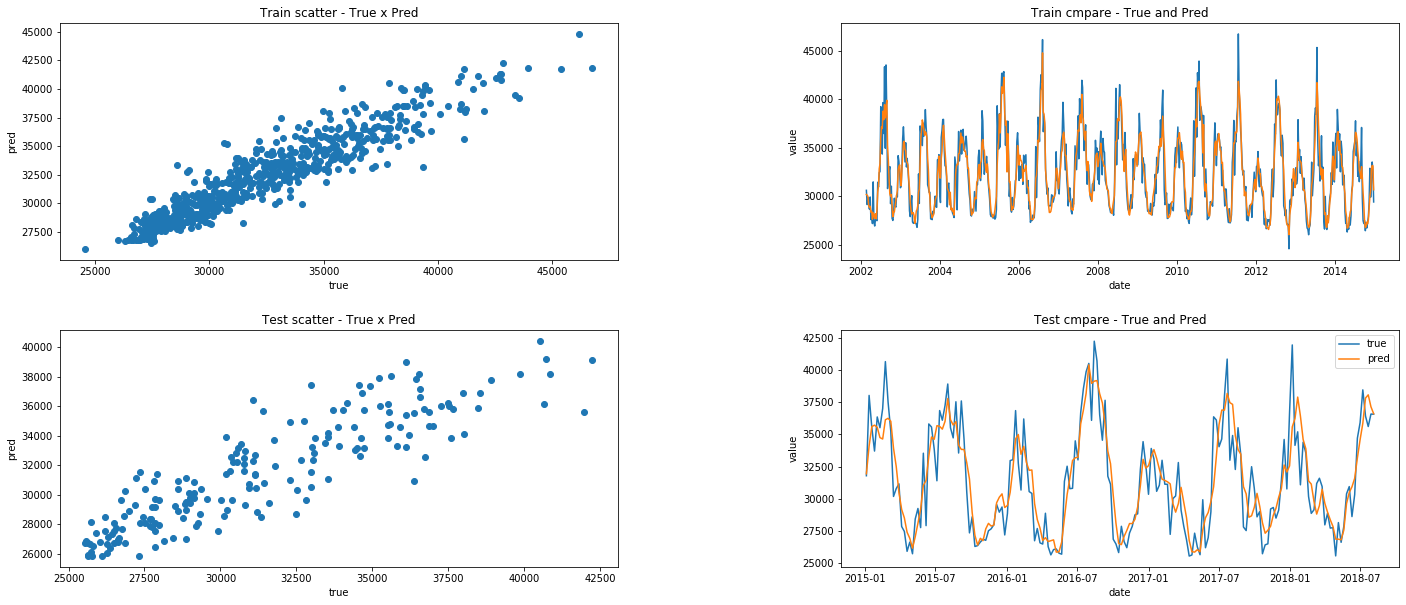

In [13]:
# best model

# spliting data
X = df_week.drop('PJME_MW', axis=1)
y = df_week['PJME_MW']

X_train, X_test, y_train, y_test = train_test_split(X, y, date='01-01-2015')

# learn gbr
model_gbr = GradientBoostingRegressor(max_depth=1, learning_rate=0.1, n_estimators=580, random_state=42)
model_gbr.fit(X_train, y_train)

# prediction
y_train_pred = model_gbr.predict(X_train)
y_test_pred = model_gbr.predict(X_test)

evaluate_pred(train_true=y_train, train_pred=y_train_pred, 
              test_true=y_test, test_pred=y_test_pred)